# SW Greenland SMB-Elevation Feedback
## Jon Maurer


In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import geojson
import xarray
import rasterio
import firedrake
from firedrake import Constant, sqrt, exp, ln, max_value, inner, grad, dx
import icepack

## Load in the inital glacier outline and make a mesh.

This glacier was initally unknown to us, but some research showed it to be the Frederikshåb Glacier, 
a piedmont glacier with some existing work done on it already (https://earthobservatory.nasa.gov/images/151638/wasting-away-again-in-greenland). 

These boundaries are hand delinated in QGIS, but the intial mesh and outline are just a starting point.

In [2]:
name = "mystery-glacier"
#name = "fred-enlarged-out2"
with open(f"{name}.geojson", "r") as outline_file:
    outline = geojson.load(outline_file)

geometry = icepack.meshing.collection_to_geo(outline)
with open(f"{name}.geo", "w") as geometry_file:
    geometry_file.write(geometry.get_code())

command = f"gmsh -2 -format msh2 -v 0 -o {name}.msh {name}.geo"
subprocess.run(command.split())

mesh = firedrake.Mesh(f"{name}.msh")

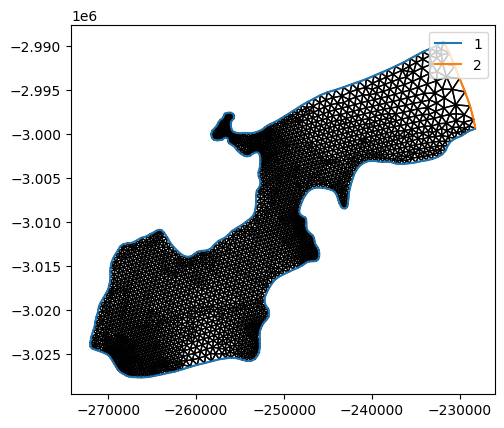

In [3]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(mesh, boundary_kw={"colors": ["tab:blue", "tab:orange"]}, axes=ax)
ax.legend();

In [4]:
cell_sizes = mesh.cell_sizes.dat.data_ro

print(f'Cells: {mesh.num_cells()}')
print(f'Min: {cell_sizes.min()} m')
print(f'Max: {cell_sizes.max()} m')
print(f'Avg: {cell_sizes.mean()} m')

Cells: 5389
Min: 174.87302076158167 m
Max: 1825.9629416818748 m
Avg: 509.1623209630997 m


Make some function spaces.

In [5]:
cg1 = firedrake.FiniteElement("CG", "triangle", 1)
dg0 = firedrake.FiniteElement("DG", "triangle", 0)

Q = firedrake.FunctionSpace(mesh, cg1)
V = firedrake.VectorFunctionSpace(mesh, cg1)

Load in the bed elevation and the ice thickness.
There's a single point where the ice thickness is zero, so clamp it below at 10m.

In [6]:
bedmachine_filename = icepack.datasets.fetch_bedmachine_greenland()
bedmachine = xarray.open_dataset(bedmachine_filename)

b = icepack.interpolate(bedmachine["bed"], Q)

h_obs = icepack.interpolate(bedmachine["thickness"], Q)
h_min = Constant(10.0)
h = firedrake.Function(Q).interpolate(max_value(h_min, h_obs))

Text(0.5, 1.0, 'Bed Machine Thickness for init. Area')

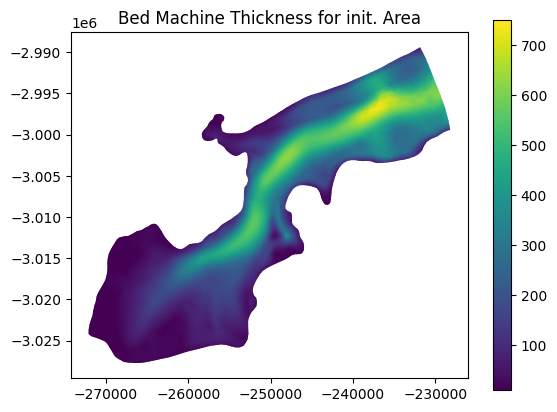

In [7]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(h, axes=ax)
fig.colorbar(colors);
ax.set_title('Bed Machine Thickness for init. Area')

In [8]:
s = firedrake.Function(Q).interpolate(b + h) # Here we define the surface as the sum of the thickness and the bed height.

Text(0.5, 1.0, 'Surface Height of init. Area')

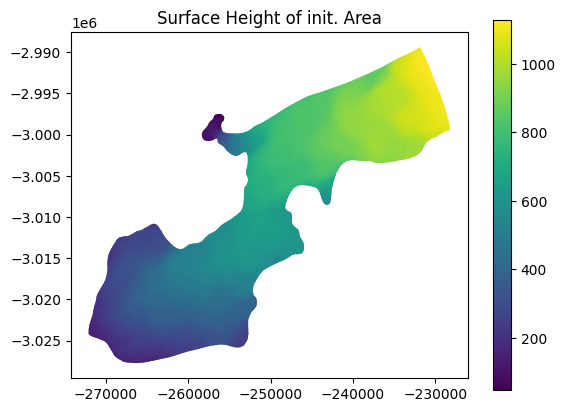

In [9]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(s, axes=ax)
fig.colorbar(colors);
ax.set_title('Surface Height of init. Area')

## Compute the driving stress, but apply a smoothing kernel to it with a smoothing length of ~1km.

In [10]:
from icepack.constants import ice_density, gravity
ρ = Constant(ice_density)
g = Constant(gravity)
τ_d = firedrake.Function(V)

δτ = τ_d + ρ * g * h * grad(s)
α = Constant(1e3)
J = 0.5 * (inner(δτ, δτ) + α**2 * inner(grad(τ_d), grad(τ_d))) * dx
F = firedrake.derivative(J, τ_d)
firedrake.solve(F == 0, τ_d)

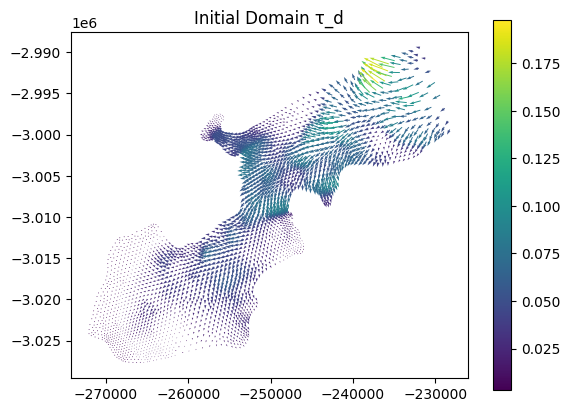

In [11]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.quiver(τ_d, axes=ax)
fig.colorbar(colors)
ax.set_title('Initial Domain τ_d');

## Load in measures velocities.

In [12]:
velocity_filenames = icepack.datasets.fetch_measures_greenland()
vx_filename = [f for f in velocity_filenames if "vx" in f][0]
vy_filename = [f for f in velocity_filenames if "vy" in f][0]
ex_filename = [f for f in velocity_filenames if "ex" in f][0]
ey_filename = [f for f in velocity_filenames if "ey" in f][0]

In [13]:
with (rasterio.open(vx_filename, "r") as vx_file,
    rasterio.open(vy_filename, "r") as vy_file):
    u_obs = icepack.interpolate((vx_file, vy_file), V)

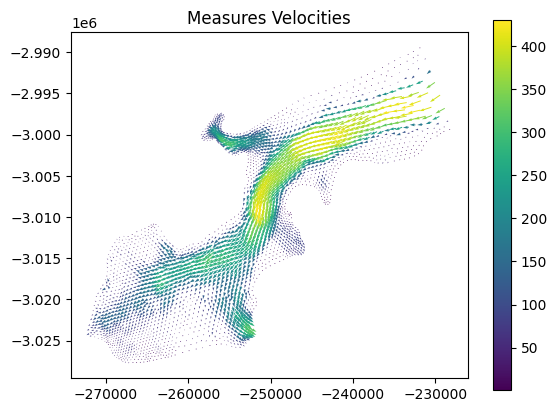

In [14]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.quiver(u_obs, axes=ax)
fig.colorbar(colors)
ax.set_title('Measures Velocities');

In [15]:
u_obs.dat.data_ro.max()

286.94508791972873

Here we're creating the statistical *precision* $P$, which is the inverse of the standard deviation.
There are some points in the domain where the velocity data is missing and thus has zero statistical precision.
Representing zero precision is fine, but if we were to use the standard deviation $\sigma$ instead, we'd have to accept infinite values of $\sigma$.

In [16]:
with rasterio.open(ex_filename, "r") as ex_file:
    σx = icepack.interpolate(ex_file, Q)

with rasterio.open(ey_filename, "r") as ey_file:
    σy = icepack.interpolate(ey_file, Q)

In [17]:
expr = 1 / sqrt(σx**2 + σy**2)
P = firedrake.Function(Q).interpolate(expr)

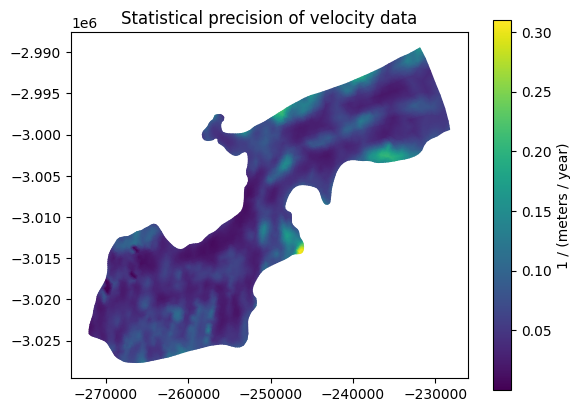

In [18]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_title("Statistical precision of velocity data")
colors = firedrake.tripcolor(P, axes=ax)
fig.colorbar(colors, label="1 / (meters / year)");

Here we're making a guess that the friction coefficient is sufficient to make basal resistance take up half the driving stress.
The sliding law is
$$\tau_b = -C|u|^{\frac{1}{m} - 1}u,$$
where $\tau_b$ is the basal shear stress, so if we want to make $|\tau_b| = f|\tau_d|$ for some fraction $f$, then
$$C = f|\tau_d| / |u|^{\frac{1}{m}}.$$
Rather than interpolate the expression directly, we're applying a smoothing kernel again.

In [19]:
from icepack.constants import weertman_sliding_law
m = Constant(weertman_sliding_law)
frac = Constant(0.8) #0.8
C_obs = frac * sqrt(inner(τ_d, τ_d)) / sqrt(inner(u_obs, u_obs)) ** (1 / m)
C = firedrake.Function(Q)

J = 0.5 * ((C - C_obs)**2 + α**2 * inner(grad(C), grad(C))) * dx
F = firedrake.derivative(J, C)
firedrake.solve(F == 0, C)

In [20]:
C.dat.data_ro.min(), C.dat.data_ro.max()

(0.000815545689970178, 0.046562072908543174)

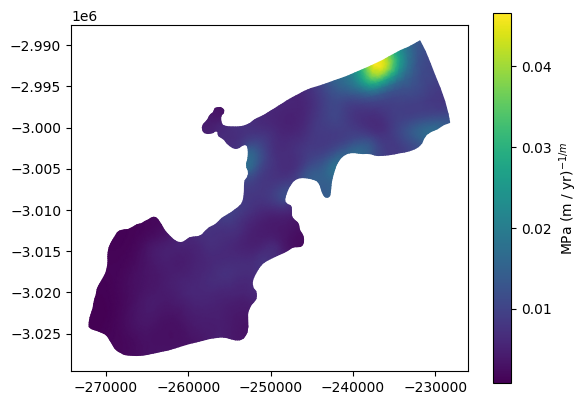

In [21]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(C, axes=ax)
fig.colorbar(colors, label="MPa (m / yr)${}^{-1/m}$");

We'll want to parameterize the sliding law in terms of the logarithm of the friction instead in order to make sure that it's positive.

In [22]:
area = firedrake.assemble(Constant(1) * dx(mesh))
C_avg = firedrake.assemble(C * dx) / area
print(f"Average friction coefficient: {1e3 * C_avg:.3f} kPa / (meters / year)^(1 / m)")

Average friction coefficient: 7.411 kPa / (meters / year)^(1 / m)


In [23]:
q = firedrake.Function(Q).interpolate(ln(C / C_avg))

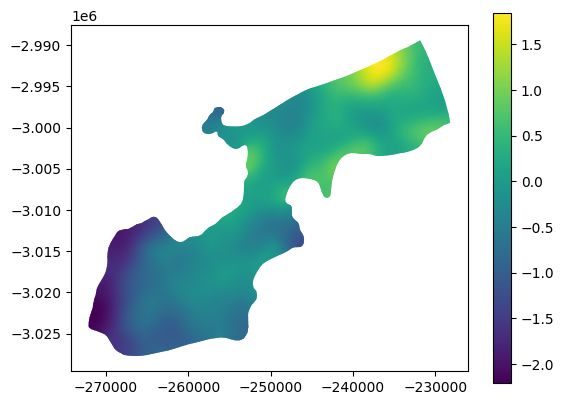

In [24]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(q, axes=ax)
fig.colorbar(colors);

Because I've messed this up once already, a bit of sanity checking.

In [25]:
firedrake.norm(C - C_avg * exp(q)) / firedrake.norm(C)

0.005003708305354065

We'll take the ice fluidity (the pre-factor in Glen's flow law) to be a constant -5C.
This is probably wrong, might want to check on that.

In [26]:
T = Constant(272.0) #268
CS = firedrake.FunctionSpace(mesh, "R", 0)
A = firedrake.Function(CS)
A.assign(icepack.rate_factor(T))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fffb37a4c10>, FiniteElement('Real', triangle, 0), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 2)), 108)

Now let's compute the ice velocity consistent with these assumptions by solving the momentum balance equation.

In [27]:
def friction(**kwargs):
    u = kwargs["velocity"]
    q = kwargs["log_friction"]
    return m / (m + 1) * C_avg * exp(q) * inner(u, u)**((m + 1) / (2 * m))

model = icepack.models.IceStream(friction=friction)
opts = {"dirichlet_ids": [1, 2]}
solver = icepack.solvers.FlowSolver(model, **opts)
u = solver.diagnostic_solve(
    velocity=u_obs, thickness=h, surface=s, fluidity=A, log_friction=q
)

We get a slightly faster ice velocity than observed but not too far off.
Try playing around with the fluidity or the shear stress fraction above to make this more sensible.

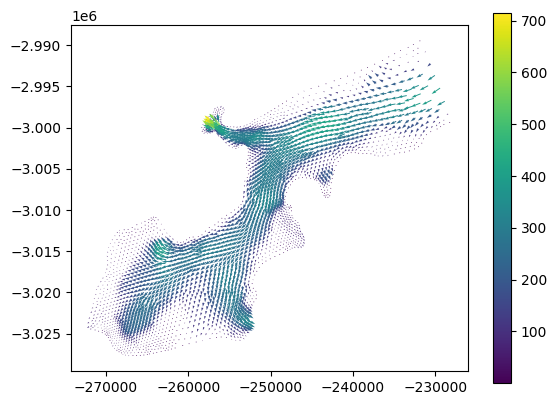

In [28]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.quiver(u, axes=ax)
fig.colorbar(colors);

In [29]:
def simulation(q):
    return solver.diagnostic_solve(
        velocity=u_obs, thickness=h, surface=s, fluidity=A, log_friction=q
    )

def loss_functional(u):
    return 0.5 * P * inner(u - u_obs, u - u_obs) * dx

λ = Constant(1000.0)
def regularization(q):
    return 0.5 * λ**2 * inner(grad(q), grad(q)) * dx

In [30]:
problem = icepack.statistics.StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=q,
)

estimator = icepack.statistics.MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-4,
    step_tolerance=1e-1,
    max_iterations=40,
)

q = estimator.solve()


Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     7.886904e+10   3.127030e+07                  1.838277e+03   
  1     4.411793e+10   1.245560e+07   1.838277e+03   4.595693e+03   3         2         0         1         3         
  2     1.895923e+10   8.286391e+06   4.595693e+03   1.148923e+04   4         3         0         3         3         
  3     1.895923e+10   8.286391e+06   1.148923e+04   7.180770e+02   5         3         2         7         3         
  4     1.588615e+10   2.378564e+06   7.180770e+02   1.795192e+03   6         4         0         2         3         
  5     1.353886e+10   3.357414e+06   1.795192e+03   4.487981e+03   7         5         0         1         3         
  6     1.024969e+10   1.838617e+06   4.487981e+03   1.121995e+04   8         6         0         6         3         
  7     1.024969e+10   1.838617e+06   1.121995e+04   7.012471e+0

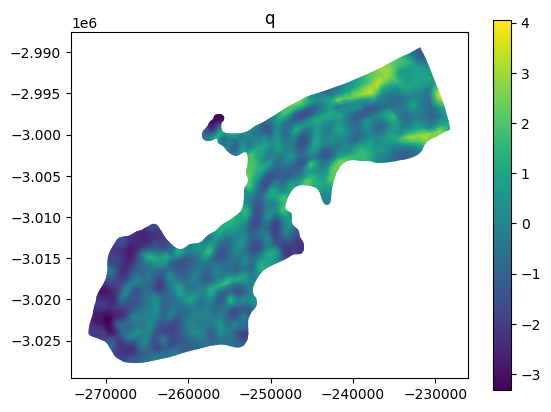

In [31]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(q, axes=ax)
fig.colorbar(colors)
ax.set_title('q');

In [32]:
u = solver.diagnostic_solve(
    velocity=u_obs, thickness=h, surface=s, fluidity=A, log_friction=q
)

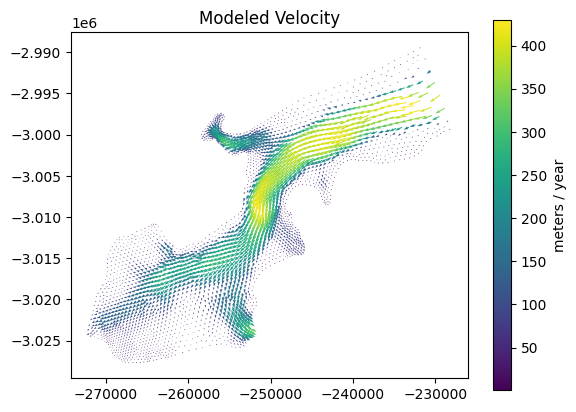

In [33]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.quiver(u, axes=ax)
fig.colorbar(colors, label="meters / year")
ax.set_title('Modeled Velocity');

In [34]:
expr = C_avg * exp(q) * sqrt(inner(u, u))**(1 / m)
τ_b = firedrake.Function(Q).interpolate(expr)

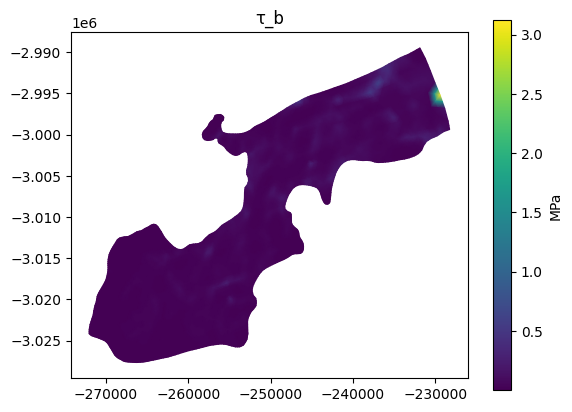

In [35]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(τ_b, axes=ax)
fig.colorbar(colors, label="MPa")
ax.set_title('τ_b');

In [36]:
expr = C_avg * exp(q) * sqrt(inner(u, u)) ** (1 / m) / sqrt(inner(τ_d, τ_d))
stress_ratio = firedrake.Function(Q).interpolate(expr)

In [37]:
τ_d.dat.data_ro.max()

0.12628698495008342

In [38]:
stress_ratio.dat.data_ro.min(), stress_ratio.dat.data_ro.max()

(0.07810502083204916, 40.43802164321094)

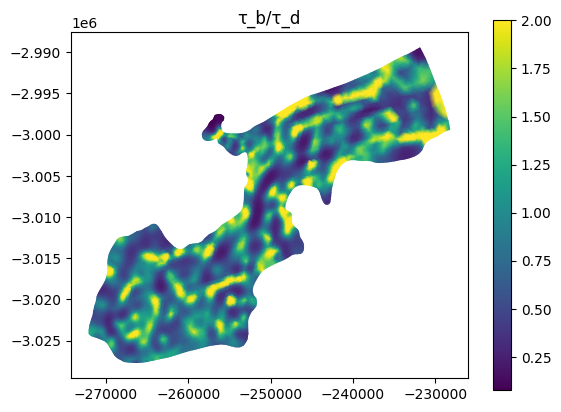

In [39]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(stress_ratio, vmax=2.0, axes=ax)
fig.colorbar(colors)
ax.set_title('τ_b/τ_d');

In [40]:
from firedrake import assemble, Constant, inner, grad, dx

area = assemble(Constant(1) * dx(mesh))
u_avg = assemble(sqrt(inner(u, u)) * dx) / area
τ_avg = assemble(sqrt(inner(τ_d, τ_d)) * dx) / area

# Extrapolating to larger domain (ice free zone for terminus)
## From extrapolate.py by Dan

In [41]:
u_input = u
q_input = q
friction_input = τ_b

τ_avg = τ_avg # Dumb but for consistency
u_avg = u_avg

Δ = firedrake.FunctionSpace(mesh, "DG", 0)
μ = firedrake.project(Constant(1), Δ)

### New domain mesh generation
Here we have an enlarged region where we can run our experiments. This area includes an expansion of the terminous as well as a step back towards the divide. 

In [42]:
import geopandas as gpd

name = "fred-divide-full"

with open(f"{name}.geojson", "r") as outline_file:
    outline = geojson.load(outline_file)

geometry = icepack.meshing.collection_to_geo(outline)
with open(f"{name}.geo", "w") as geometry_file:
    geometry_file.write(geometry.get_code())

command = f"gmsh -2 -format msh2 -v 0 -o {name}.msh {name}.geo"
subprocess.run(command.split())

initial_mesh = firedrake.Mesh(f"{name}.msh")
mesh_hierarchy = firedrake.MeshHierarchy(initial_mesh, 1, 3)
mesh = mesh_hierarchy[-1]

Beyond the single mesh plotted here, we have constructed a hierarchy of meshes which allows us to experiment with the refinement needed in some of the tricky spots within our domain.It is currently set to generate 3 meshes, each an order of magnitude more refined than the last. Currently we are using the most refined version, but long term this may not be explictly needed.

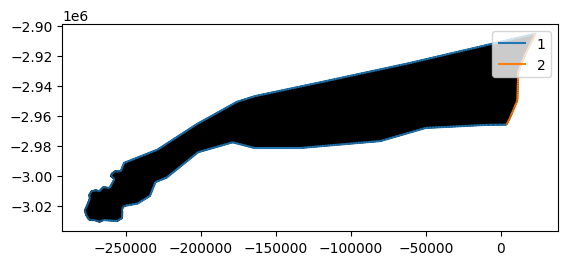

In [43]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(mesh, boundary_kw={"colors": ["tab:blue", "tab:orange"]}, axes=ax)
ax.legend();

In [44]:
cell_sizes = mesh.cell_sizes.dat.data_ro

print(f'Cells: {mesh.num_cells()}')
print(f'Min: {cell_sizes.min()} m')
print(f'Max: {cell_sizes.max()} m')
print(f'Avg: {cell_sizes.mean()} m')

Cells: 35904
Min: 120.41645069969286 m
Max: 1523.2398355882472 m
Avg: 847.8761209916764 m


In [45]:
# New function Spaces from new mesh
Q = firedrake.FunctionSpace(mesh, "CG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1)

In [46]:
# Project the mask, log-fluidity, and velocity onto the larger mesh. The
# regions with no data will be extrapolated by zero.
Δ = firedrake.FunctionSpace(mesh, "DG", 0)
μ = firedrake.project(μ, Δ)

In [47]:
Eq = firedrake.project(q_input, Q)
Eu = firedrake.project(u_input, V)
Efrict = firedrake.project(friction_input, Q)

q = Eq.copy(deepcopy=True)
u = Eu.copy(deepcopy=True)
τ_b = Efrict.copy(deepcopy=True) 

α = Constant(5e2)

In [48]:
# Extrapolate Velocity to new mesh
bc_ids = [1, 2]
bc = firedrake.DirichletBC(V, Eu, bc_ids)
J = 0.5 * (μ * inner(u - Eu, u - Eu) + α**2 * inner(grad(u), grad(u))) * dx
F = firedrake.derivative(J, u)
firedrake.solve(F == 0, u, bc)

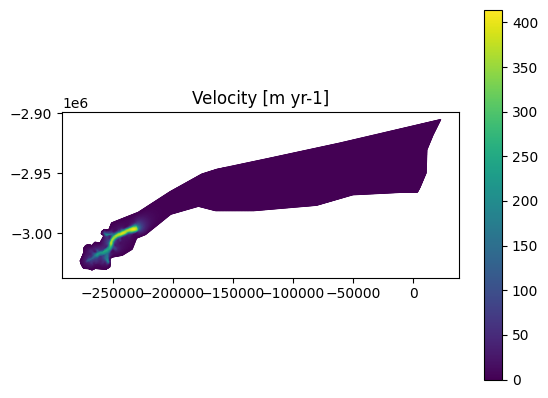

In [49]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(u, axes=ax)
fig.colorbar(colors)
ax.set_title('Velocity [m yr-1]');

In [50]:
# Extrapolate friction coef. to new mesh
bc = firedrake.DirichletBC(Q, Eq, bc_ids)
J = 0.5 * (μ * inner(q - Eq, q - Eq) + α**2 * inner(grad(q), grad(q))) * dx
F = firedrake.derivative(J, q)
firedrake.solve(F == 0, q, bc)

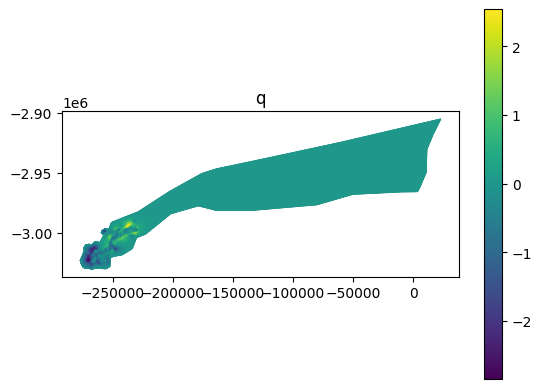

In [51]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(q, axes=ax)
fig.colorbar(colors)
ax.set_title('q');

In [52]:
bedmachine = xarray.open_dataset(icepack.datasets.fetch_bedmachine_greenland())
h_obs = icepack.interpolate(bedmachine["thickness"], Q)

In [53]:
# Extrapolate thickness 
h = h_obs.copy(deepcopy=True)
λ = Constant(2e3)
J = 0.5 * ((h - h_obs)**2 + λ**2 * inner(grad(h), grad(h))) * dx
F = firedrake.derivative(J, h)
firedrake.solve(F == 0, h)

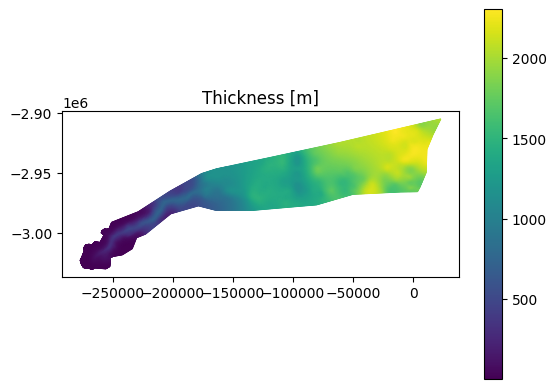

In [54]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(h, axes=ax)
fig.colorbar(colors)
ax.set_title('Thickness [m]');

In [55]:
# Extrapolate basal friction
bc = firedrake.DirichletBC(Q, Efrict, bc_ids)
J = 0.5 * (μ * inner(τ_b - Efrict, τ_b - Efrict) + α**2 * inner(grad(τ_b), grad(τ_b))) * dx
F = firedrake.derivative(J, τ_b)
firedrake.solve(F == 0, τ_b, bc)

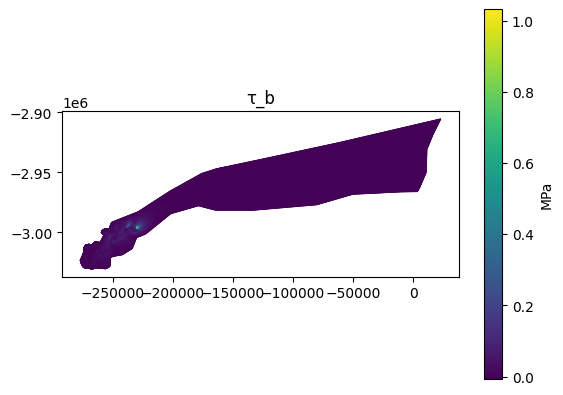

In [56]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(τ_b, axes=ax)
fig.colorbar(colors, label="MPa")
ax.set_title('τ_b');

# Time Dependent Foward Modeling
## From simulate.py by Dan

In [57]:
import argparse
import subprocess
import tqdm
import numpy as np
from numpy import pi as π
import xarray
import firedrake
from firedrake import assemble, Constant, exp, max_value, inner, grad, dx, ds, dS
import icepack
from icepack2.constants import (
    glen_flow_law as n,
    weertman_sliding_law as m,
    ice_density as ρ_I,
    water_density as ρ_W,
)
from icepack2 import model

## Start by showing where we initialize our run

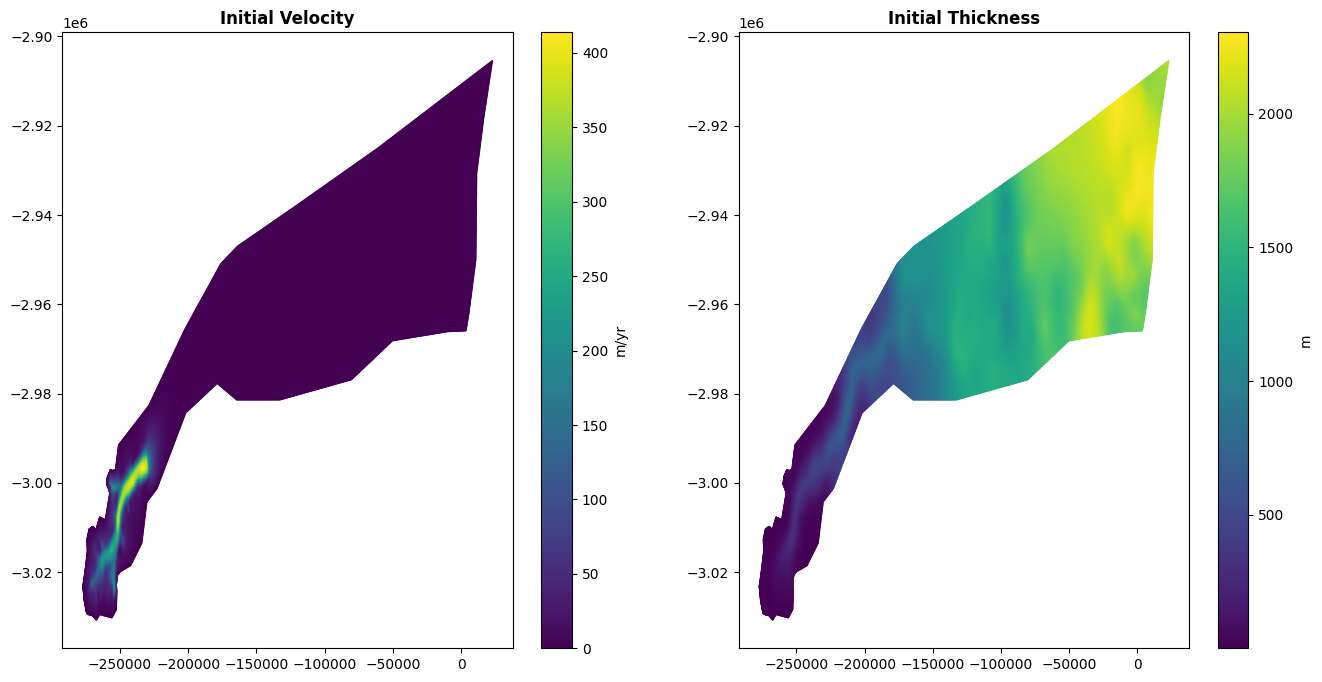

In [58]:
# Initial Conditions 
fig, ax = plt.subplots(1, 2, figsize = [16, 8])

ax[0].set_title('Initial Velocity', fontweight = 'bold')
arrows = firedrake.tripcolor(u, axes=ax[0])#vmax = 15)
fig.colorbar(arrows, label="m/yr")

ax[1].set_title('Initial Thickness', fontweight = 'bold')
colors = firedrake.tripcolor(h, axes=ax[1])
fig.colorbar(colors, label = 'm')

## Run parameters

In [59]:
timesteps_per_year = 1
final_time = 4000
calving = False # When running to sealevel
melt_rate = 3e3
mask_smoothing_length = 5e3
snes_max_it = 200
snes_rtol = 1e-5

In [60]:
Q = firedrake.FunctionSpace(mesh, "CG", 2) # Changed from 1
Δ = firedrake.FunctionSpace(mesh, "DG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1) # Changed from 1
Σ = firedrake.TensorFunctionSpace(mesh, "DG", 0, symmetry=True)
T = firedrake.VectorFunctionSpace(mesh, "DG", 0)
Z = V * Σ * T

In [61]:
u_in = firedrake.project(u, V)
q = firedrake.project(q, Q)

z = firedrake.Function(Z)
z.sub(0).assign(u_in)

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fff9c52bb20>, VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), name=None, index=0, component=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 79011)), 110507)

In [62]:
# Read the thickness and bed data
bedmachine = xarray.open_dataset(icepack.datasets.fetch_bedmachine_greenland())
b = icepack.interpolate(bedmachine["bed"], Q)
h = firedrake.project(h, Δ)
s = firedrake.project(max_value(b + h, (1 - ρ_I / ρ_W) * h), Δ)

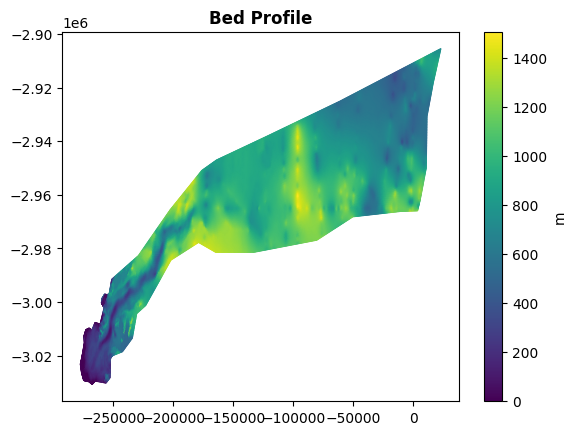

In [63]:
fig, ax = plt.subplots()
ax.set_title('Bed Profile', fontweight = 'bold')
arrows = firedrake.tripcolor(b, axes=ax)#vmax = 15)
fig.colorbar(arrows, label="m")

### Note the deep chanel incision that runs all the way back towards the divide. If we allow advancement to the coast this may cause some headache later on.

In [64]:
# Set up the momentum balance equation and solve
A = icepack.rate_factor(Constant(272.0))
τ_c = τ_avg
u_c = u_avg
ε_c = Constant(A * τ_c ** n)

print(f"τ_c: {1000 * float(τ_c):.1f} kPa")
print(f"ε_c: {1000 * float(ε_c):.1f} (m / yr) / km")
print(f"u_c: {float(u_c):.1f} m / yr")

τ_c: 42.7 kPa
ε_c: 9.6 (m / yr) / km
u_c: 147.9 m / yr


In [65]:
fns = [
    model.viscous_power,
    model.friction_power,
    #model.calving_terminus,
    model.momentum_balance,
]

In [66]:
u, M, τ = firedrake.split(z)
fields = {
    "velocity": u,
    "membrane_stress": M,
    "basal_stress": τ,
    "thickness": h,
    "surface": s,
}

In [67]:
h_min = Constant(1e-3)
rfields = {
    "velocity": u,
    "membrane_stress": M,
    "basal_stress": τ,
    "thickness": max_value(h_min, h),
    "surface": s,
}

In [68]:
rheology = {
    "flow_law_exponent": n,
    "flow_law_coefficient": ε_c / τ_c**n,
    "sliding_exponent": m,
    "sliding_coefficient": u_c / τ_c**m * exp(m * q),
}

In [69]:
linear_rheology = {
    "flow_law_exponent": 1,
    "flow_law_coefficient": ε_c / τ_c,
    "sliding_exponent": 1,
    "sliding_coefficient": u_c / τ_c * exp(q),
}

In [70]:
L_1 = sum(fn(**rfields, **linear_rheology) for fn in fns)
F_1 = firedrake.derivative(L_1, z)
J_1 = firedrake.derivative(F_1, z)

In [71]:
L = sum(fn(**fields, **rheology) for fn in fns)
F = firedrake.derivative(L, z)

In [72]:
L_r = sum(fn(**rfields, **rheology) for fn in fns)
F_r = firedrake.derivative(L_r, z)
J_r = firedrake.derivative(F_r, z)
α = firedrake.Constant(0.0)
J = J_r + α * J_1

In [73]:
inflow_ids = [1]
bc_in = firedrake.DirichletBC(Z.sub(0), u_in, inflow_ids)
outflow_ids = [2]
bc_out = firedrake.DirichletBC(Z.sub(0), Constant((0.0, 0.0)), outflow_ids)
bcs = [bc_in, bc_out]

In [74]:
qdegree = int(max(m, n)) + 2
problem_params = {
    "form_compiler_parameters": {"quadrature_degree": qdegree},
    "bcs": bcs,
}
solver_params = {
    "solver_parameters": {
        "snes_monitor": None,
        #"snes_converged_reason": None,
        "snes_stol": 0.0,
        "snes_rtol": 1e-5,
        "snes_linesearch_type": "nleqerr",
        "snes_max_it": 200,
        "snes_divergence_tolerance": -1,
        "snes_type": "newtonls",
        "ksp_type": "gmres",
        "pc_type": "lu",
        # If the linear solver crashes, try "umfpack" instead of "mumps"
        "pc_factor_mat_solver_type": "umfpack",
    },
}
firedrake.solve(F_1 == 0, z, **problem_params, **solver_params)

  0 SNES Function norm 2.001120162138e+09
  1 SNES Function norm 2.688494190610e-03


In [75]:
u_problem = firedrake.NonlinearVariationalProblem(F, z, J=J, **problem_params)
u_solver = firedrake.NonlinearVariationalSolver(u_problem, **solver_params)
u_solver.solve()

  0 SNES Function norm 3.873343192736e+11


ConvergenceError: Nonlinear solve failed to converge after 0 nonlinear iterations.
Reason:
   DIVERGED_LINEAR_SOLVE

### SMB ~= a_0 + (da_ds * s)

In [ ]:
da_ds_val = 2.25 * 1e-3 #2.25
da_ds = Constant(da_ds_val)
    
a_val = -1.4
a_0 = Constant(a_val) #-2.3

ela = a_val / da_ds_val
print(f' Calculated ELA is {- ela}')

smb = 0.917 * (a_0 + da_ds * s)

a = firedrake.Function(Q).interpolate(smb)

In [ ]:
# SMB Plot
# Inputs
z_max = s.dat.data_ro.max()
z_min = s.dat.data_ro.min()
z_vals = np.arange(z_min, z_max, 1)

x_coords = np.arange(0, len(z_vals), 1) # Dummy values of ~ len 10km for plotting
s_vals = 0.917 * (a_val + da_ds_val * z_vals)

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(x_coords, s_vals, '-')
plt.title('SMB Gradient')
plt.ylabel('Amount added to Z [m]')
plt.xlabel('X position [m]')
plt.axhline(y = 0, linestyle = '--', color = 'red')

## At this pt, our glacier has a response time that we can calculate
### τ = h / b_t

In [ ]:
response_time = h.dat.data_ro.mean() / a_val
print(f'Response time is ~{response_time:.2f} years')
print(f"Current run is for ~ {final_time / response_time:.2f} τ's")

In [ ]:
# Create a solver for a smooth ice mask field
if calving == True:
    α = Constant(args.mask_smoothing_length)
    μ = firedrake.Function(Q)
    χ = firedrake.conditional(h > 0, 1, 0)
    J = 0.5 * ((μ - χ)**2 + α**2 * inner(grad(μ), grad(μ))) * dx
    bcs = [
        firedrake.DirichletBC(Q, Constant(1.0), (1,)),
        firedrake.DirichletBC(Q, Constant(0.0), (3,)),
    ]
    F = firedrake.derivative(J, μ)
    μ_problem = firedrake.NonlinearVariationalProblem(F, μ, bcs)
    μ_solver = firedrake.NonlinearVariationalSolver(μ_problem)
    μ_solver.solve()

In [ ]:
# Create the accumulation/ablation function, which is a sum of SMB and calving
# losses (if any)
t = Constant(0.0)
if calving == True:
    m = Constant(args.melt_rate)  # melt rate in m/yr
    φ = firedrake.min_value(0, firedrake.cos(2 * π * t))
    calving = m * (1 - μ) * φ
    a = smb + calving
else:
    a = smb

In [ ]:
# Set up the mass balance equation
h_n = h.copy(deepcopy=True)
h0 = h.copy(deepcopy=True)
φ = firedrake.TestFunction(h.function_space())
dt = Constant(1.0 / 96)
flux_cells = ((h - h_n) / dt * φ - inner(h * u, grad(φ)) - a * φ) * dx
ν = firedrake.FacetNormal(mesh)
f = h * max_value(0, inner(u, ν))
flux_facets = (f("+") - f("-")) * (φ("+") - φ("-")) * dS
flux_in = h0 * firedrake.min_value(0, inner(u, ν)) * φ * ds
flux_out = h * max_value(0, inner(u, ν)) * φ * ds
G = flux_cells + flux_facets + flux_in + flux_out
h_problem = firedrake.NonlinearVariationalProblem(G, h)
h_solver = firedrake.NonlinearVariationalSolver(h_problem)

In [ ]:
### Run the simulation
num_steps = int(final_time * timesteps_per_year) + 1

dh_max = np.zeros(num_steps) * np.nan
hs = [h.copy(deepcopy=True)]
h_c = Constant(5.0)

with firedrake.CheckpointFile('mystery-glacier-simulation.h5', "w") as chk:
    u, M, τ = z.subfunctions
    chk.save_function(h, name="thickness", idx=0)
    chk.save_function(u, name="velocity", idx=0)
    chk.save_function(M, name="membrane_stress", idx=0)
    chk.save_function(τ, name="basal_stress", idx=0)
    if calving == True:
        chk.save_function(μ, name="ice_mask", idx=0)

    timesteps = np.linspace(0.0, final_time, num_steps)
    for step in tqdm.trange(num_steps):
        t.assign(t + dt)
        #s.assign(s)
        if calving == True:
            μ_solver.solve()
 
        h_solver.solve()
        h.interpolate(firedrake.conditional(h < h_c, 0, h))
        h_n.assign(h)
        hs.append(h.copy(deepcopy=True))
        dh_max[step] = h.dat.data_ro.max()
        
        s.interpolate(max_value(b + h, (1 - ρ_I / ρ_W) * h))
        u_solver.solve()

        # Save the results to disk
        u, M, τ = z.subfunctions
        chk.save_function(h, name="thickness", idx=step + 1)
        chk.save_function(u, name="velocity", idx=step + 1)
        chk.save_function(M, name="membrane_stress", idx=step + 1)
        chk.save_function(τ, name="basal_stress", idx=step + 1)
        if calving == True:
            chk.save_function(μ, name="ice_mask", idx=step + 1)

    chk.save_function(q, name="log_friction")
    chk.h5pyfile.attrs["mean_stress"] = τ_c
    chk.h5pyfile.attrs["mean_speed"] = u_c
    chk.h5pyfile.create_dataset("timesteps", data=timesteps)

In [ ]:
print(s.dat.data_ro.min())
print(s.dat.data_ro.max())

print(h.dat.data_ro.mean())

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = [16, 8])

ax[0].set_title('Velocity', fontweight = 'bold')
arrows = firedrake.tripcolor(u, axes=ax[0])#vmax = 15)
fig.colorbar(arrows, label="m/yr")

ax[1].set_title('Thickness', fontweight = 'bold')
colors = firedrake.tripcolor(h, axes=ax[1], vmin = 0)
fig.colorbar(colors, label = 'm')

In [ ]:
# Difference plot 
δh = firedrake.project(hs[-1] - hs[0], hs[0].function_space())
change_max = δh.dat.data_ro.max()
change_min = δh.dat.data_ro.min()

fig, axes = plt.subplots()
axes.set_aspect("equal")
axes.set_title("Difference Plot")
colors = firedrake.tripcolor(δh, 
                             num_sample_points=1, 
                             shading="flat", 
                             cmap="RdBu",
                             vmin = -300, vmax = 300, 
                             axes=axes)

fig.colorbar(colors);

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#%% capture
hmax = hs[0].dat.data_ro.max()

fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(hs[0], vmin=0, vmax=hmax, axes=ax, num_sample_points=4)
fig.colorbar(colors)
fn_plotter = firedrake.FunctionPlotter(mesh, num_sample_points=4)
plt.xticks(rotation=45);

def animate(h):
    colors.set_array(fn_plotter(h))

animation = FuncAnimation(fig, animate, hs[::5], interval=1e3/30)

HTML(animation.to_jshtml())

In [ ]:
plt.figure()
plt.plot(dh_max)

plt.xlabel("steps")
plt.ylabel("Maximum Thickness (meters)")
plt.title("Max Ice Thickness at each Time Step");

- Running for number of steps vs year w/ number of timesteps returns the same result. For example, running for 2000 years at an annual time step gives the same plot as 1000 years w/ 2x/yr resolution.
- need smb-divergence plot